# Introduction

You probably want to do a similar coastal kelvin and Rossby wave propagation diagnostic for IOD and compare it to the SSH available.

What possible plots could you make?

Your coastal SLA diagrams could be useful.

Do a std of all data at a point versus seasonal plot and compare to SSH form real.

Does this need to be an SLA anomaly?

You should detrend 

regrid sla obs to model ssh since it's coarser

# Setup

In [1]:
# import your standard packages and parameters
%run ../pkgs.py
%run ../pars.py

# import your local functions
sys.path.insert(1, '../')
from local_functions import *
from MOM6_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Paths and Fns

In [2]:
inpath = '/scratch/gpfs2/GEOCLIM/LRGROUP/Liao/MOM6-regional-0522-2021/ice_ocean_SIS2/regional_IndianOcean_control_config_025_correctaxis/'
outpath = '../../data/'

outfn = 'sla_regional_processed.nc'

# Get Regional Data

In [3]:
fns = sorted(glob.glob(inpath +'*dynamics2d_monthly*.nc')) # sorted() makes sure the files are sorted in time

# merge all ssh into one file
cnt = 0;
for ff, fn in enumerate(fns[:-1]):
    ds_in = xr.open_dataset(fn)
    
    print('processing: ', fn[-7:-3])
    
    if ff == 0:
        # intialize
        ssh = ds_in.SSH
        lat = np.array(ds_in.geolat)
        lon = np.array(ds_in.geolon)
    else:
        # add on current time step along time dimension
        ssh = xr.concat((ssh,ds_in.SSH),dim = 'time')
    
    cnt = cnt + ds_in.time.shape[0]

print('ssh final shape',ssh.shape)

processing:  2009
processing:  2010
processing:  2011
processing:  2012
processing:  2013
processing:  2014
processing:  2015
processing:  2016
processing:  2017
ssh final shape (108, 256, 428)


In [4]:
lat[0,0], lat[-1,0]

(-30.455408, 30.239664)

In [5]:
lon[0,0], lon[0,-1]

(29.375, 136.125)

In [6]:
# convert to xarray dataset
ds_out = xr.Dataset(coords={'time': ssh.time,
                       'lat': lat[:,0],
                       'lon': lon[0,:]})

# add variables to dataset
ds_out['mon_ssh']=xr.DataArray(np.array(ssh),dims = ['time','lat', 'lon'],
                     coords =[ssh.time,lat[:,0],lon[0,:]])
# convert to datetime format
datetimeindex = ds_out.indexes['time'].to_datetimeindex()
ds_out['time'] = datetimeindex
ds_out

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  # Remove the CWD from sys.path while we load stuff.


<xarray.Dataset>
Dimensions:  (lat: 256, lon: 428, time: 108)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-16T12:00:00 ... 2017-12-16T12:00:00
  * lat      (lat) float32 -30.455408 -30.239664 ... 30.023445 30.239664
  * lon      (lon) float32 29.375 29.625 29.875 ... 135.625 135.875 136.125
Data variables:
    mon_ssh  (time, lat, lon) float32 nan nan nan ... 0.80996394 0.77636755

# Regrid to uniform, nominal 0.25 degree lat lon

In [7]:
# to do this part again, comment previous cell and uncomment below

# # convert to xarray dataset
# ds = xr.Dataset(coords={'time': ssh.time})

# # add variables to dataset
# ds['mon_ssh']=xr.DataArray(ssh,dims = ['time','dimy', 'dimx'],
#                      coords =[ssh.time,np.arange(ssh.shape[1]),np.arange(ssh.shape[2])])
# ds['lat']=xr.DataArray(lat,dims = ['dimy', 'dimx'],
#                      coords =[np.arange(ssh.shape[1]),np.arange(ssh.shape[2])])
# ds['lon']=xr.DataArray(lon,dims = ['dimy', 'dimx'],
#                      coords =[np.arange(ssh.shape[1]),np.arange(ssh.shape[2])])
# # convert to datetime format
# datetimeindex = ds.indexes['time'].to_datetimeindex()
# ds['time'] = datetimeindex
# ds

# lat = np.arange(ds.lat.min(),ds.lat.max(),0.25)
# lon = np.arange(ds.lon.min(),ds.lon.max(),0.25)

# xx = np.array(ds.lon).flatten()
# yy = np.array(ds.lat).flatten()

# xx_new,yy_new = np.meshgrid(lon,lat)

# mon_ssh_new = np.zeros((len(ds.time),len(lat),len(lon)))*np.nan

# for tt in tqdm(range(len(ds.time))):

#     temp_ssh = np.array(ds.mon_ssh[tt,:,:])

#     points = np.array( (xx,yy) ).T
#     temp_values = temp_ssh.flatten()

#     mon_ssh_new[tt,:,:] = griddata(points, temp_values, (xx_new,yy_new) ,method='linear')

# ds_out = xr.Dataset(coords={'time': ds.time,
#                         'lon': lon,
#                         'lat': lat})
# coords = [ds.time,lat,lon]
# dims = ['time','lat','lon']

# # add to dataset
# ds_out['mon_ssh'] = xr.DataArray(mon_ssh_new,dims = dims,coords = coords)

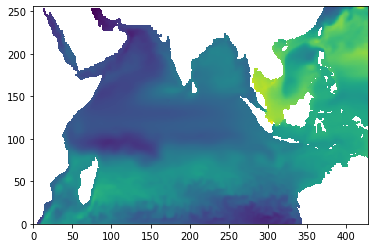

In [8]:
plt.pcolor(ds_out.mon_ssh[0,:,:])

# Find SLA anomaly relative to total mean

In [9]:
mean_ssh = ds_out.mon_ssh.mean(dim = 'time')
mon_sla = ds_out.mon_ssh - mean_ssh

ds_out['mon_sla']=xr.DataArray(mon_sla,dims = ['time','lat', 'lon'],
                     coords =[ds_out.time,ds_out.lat,ds_out.lon])

lat = np.array(ds_out.lat)
lon = np.array(ds_out.lon)
ds_out

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (lat: 256, lon: 428, time: 108)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-16T12:00:00 ... 2017-12-16T12:00:00
  * lat      (lat) float32 -30.455408 -30.239664 ... 30.023445 30.239664
  * lon      (lon) float32 29.375 29.625 29.875 ... 135.625 135.875 136.125
Data variables:
    mon_ssh  (time, lat, lon) float32 nan nan nan ... 0.80996394 0.77636755
    mon_sla  (time, lat, lon) float32 nan nan nan ... -0.027657747 -0.037216365

# Detrend

In [10]:
%%time

# stack lat and lon into a single dimension called allpoints
stacked = mon_sla.stack(allpoints=['lat','lon'])

# set places where there are nans to zero since polyfit can't deal with them
stacked_nonan = stacked.fillna(0)

# convert date to a number to polyfit can handle it
datenum = dates.date2num(stacked_nonan.time)
mon_sla_slope, mon_sla_intercept = np.polyfit(datenum, stacked_nonan, 1)

#reshape the data
mon_sla_slope = np.reshape(mon_sla_slope, mon_sla.shape[1:3])
mon_sla_intercept = np.reshape(mon_sla_intercept, mon_sla.shape[1:3])

# define a function to compute a linear trend of a timeseries
def linear_detrend(y):
    x = dates.date2num(y.time)
    m, b = np.polyfit(x, y, 1)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(y - (m*x + b))

# apply the function over allpoints to calculate the trend at each point
mon_sla_dtrnd = stacked_nonan.groupby('allpoints').apply(linear_detrend)
# unstack back to lat lon coordinates
mon_sla_dtrnd = mon_sla_dtrnd.unstack('allpoints')

# fill all points we set originally to zero back to nan
mon_sla_dtrnd = mon_sla_dtrnd.where(~np.isnan(mon_sla))

CPU times: user 2min 56s, sys: 3.21 s, total: 2min 59s
Wall time: 2min 45s


# Plot

/home/jennap/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Time')

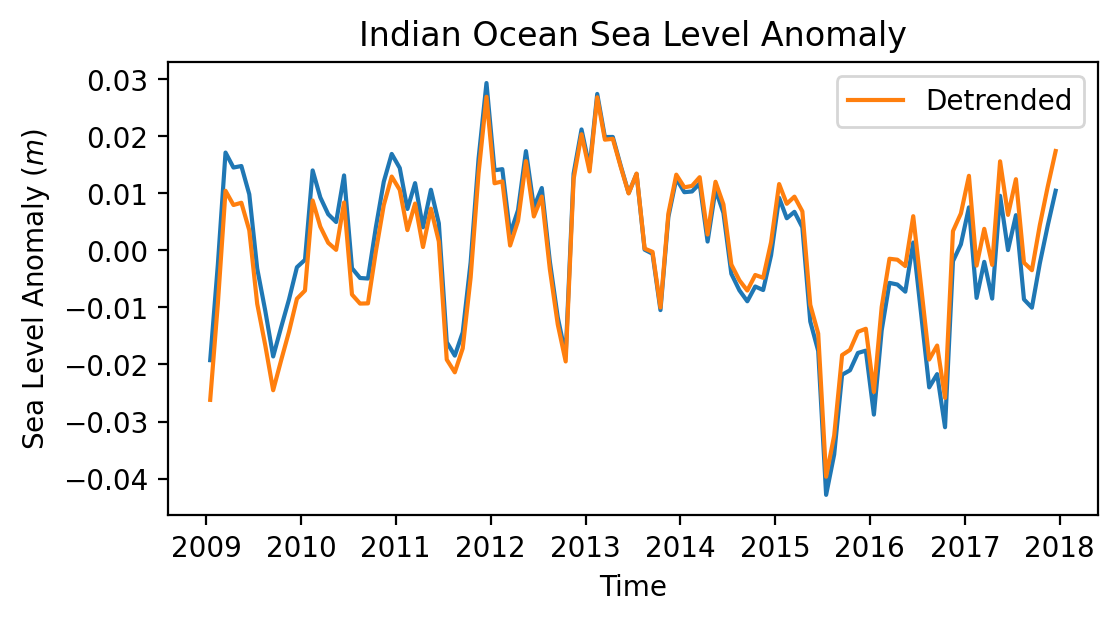

In [11]:
# find global means for comparison
stacked = mon_sla.stack(allpoints=['lat','lon'])
global_mean = stacked.mean(dim='allpoints',skipna=True)
# global_mean.plot()

# find global means for comparison 
stacked = mon_sla_dtrnd.stack(allpoints=['lat','lon'])
global_mean_dtrnd = stacked.mean(dim='allpoints',skipna=True)
# global_mean_dtrnd.plot()
# plt.legend


fig = plt.figure(figsize=(6,3),dpi=200)
plt.plot(global_mean.time,global_mean)
plt.plot(global_mean_dtrnd.time,global_mean_dtrnd, label = 'Detrended')
plt.legend()
plt.title('Indian Ocean Sea Level Anomaly')
plt.ylabel('Sea Level Anomaly ($m$)')
plt.xlabel('Time')

# Monthly Climatology

In [12]:
# monthly clim
mon_sla_mon_clim = monthly_clim(mon_sla_dtrnd)
# monthly anom = monthly avg data - monthly climatology
mon_sla_mon_anom = mon_sla_dtrnd.groupby('time.month') - mon_sla_mon_clim


/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Find Coastlines

In [13]:
# ------------------------------------------------------------#
# block out a few places that you don't want to include
# ------------------------------------------------------------#

mask = mon_sla_dtrnd[0,:,:]
xx,yy = np.meshgrid(lon,lat)

In [14]:
mask.shape

(256, 428)

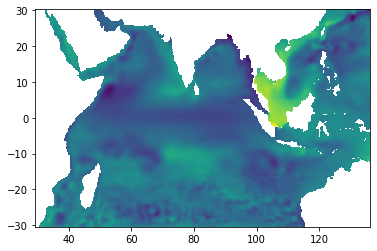

In [15]:
plt.pcolor(xx,yy,mask)

Text(0.5, 1.0, 'Unordered Stations')

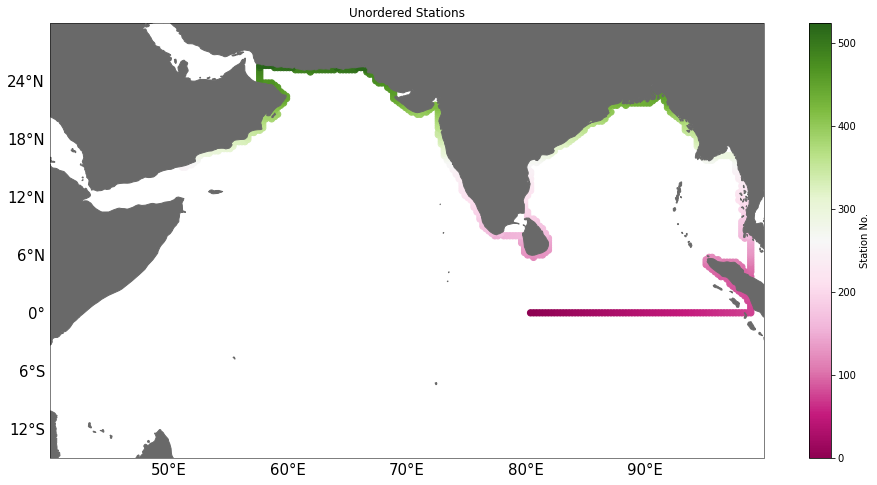

In [16]:
# set Gulfs to Nans
mask = mask.where(~((yy>22) & (xx<57.5)))
mask = mask.where(~((yy>10) & (xx<51)))

# AS inlets
mask = mask.where(~((yy>21.5) & (yy<23) & (xx>72) & (xx<73)))
mask = mask.where(~((yy>22.25) & (yy<23) & (xx>69) & (xx<70.5)))
mask = mask.where(~((yy>23.25) & (yy<24) & (xx>68.5) & (xx<70)))

# sri lanka are
mask = mask.where(~((yy>8) & (yy<10.5) & (xx>78) & (xx<80)))

# Sumatra area
mask = mask.where(~((yy>1.5) & (yy<3) & (xx>95.75) & (xx<96.25)),1)
mask = mask.where(~((yy>.25) & (yy<2.25) & (xx>97) & (xx<98)),1)
mask = mask.where(~((yy>.25) & (yy<1.75) & (xx>98) & (xx<98.5)),1)

#EBoB
mask = mask.where(~((yy<6) & (xx>99)),1)
mask = mask.where(~((yy>4) & (yy<8) & (xx>99)))
# mask = mask.where(~((yy>9.3) & (yy<12) & (xx>96)))
mask = mask.where(~((yy>9.5) & (yy<10.2) & (xx>96) & (xx<98.3)),1)
mask = mask.where(~((yy>16.5) & (xx>96.25) & (xx<97.4)))


#Sococtra
mask = mask.where(~((yy>6) & (yy<13) & (xx>50) & (xx<60)),1)
                  
# Nicobar/andaman
mask = mask.where(~((yy>9) & (yy<17) & (xx>91) & (xx<95)),1)

# equator
mask = mask.where(~(yy<0))
mask = mask.where(~((yy<1) & (xx>99)))
# ------------------------------------------------------------#
# locate points along the BoB and AS
# ------------------------------------------------------------#

sta_latinds_unord, sta_loninds_unord = find_coast(np.array(mask))
# ------------------------------------------------------------#
# Remove Manually some other points
# ------------------------------------------------------------#

sta_latinds_unord = sta_latinds_unord[150:]
sta_loninds_unord = sta_loninds_unord[150:]

# AS
lons_from_sta = lon[sta_loninds_unord]
lats_from_sta = lat[sta_latinds_unord]

ind = ~((lons_from_sta <52) & (lats_from_sta < 15))
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

#BoB
lons_from_sta = lon[sta_loninds_unord]
lats_from_sta = lat[sta_latinds_unord]

ind = ~(lons_from_sta >99)
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#

bounds = [96,98,10,20]
bounds = [40,100,-15,30]

    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds=bounds)
# cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
plt.scatter(lon[sta_loninds_unord],lat[sta_latinds_unord],
            s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
# plt.scatter(lon[sta_mask],lat[sta_mask],
#             s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
plt.colorbar(label = 'Station No.')
plt.title('Unordered Stations')

No Next Station Found. Returning Previous Stations Only.
(87, 189) [(278, 143), (278, 128), (245, 223), (245, 222), (245, 221)]
lons:  [80.375 98.875 88.375 80.375 63.375 51.125]
lats:  [ 0.          0.49999365 21.478516    5.9890637  25.151031   15.073067  ]


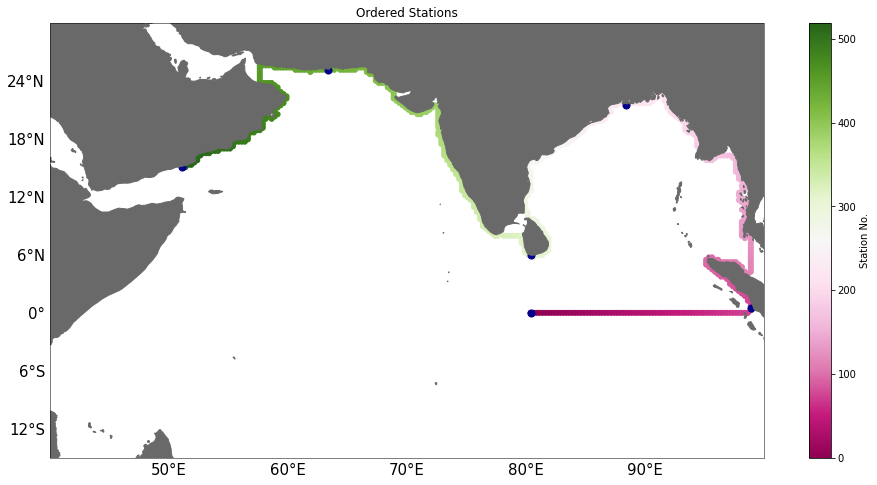

In [17]:
# ------------------------------------------------------------#
# put in the right order
# ------------------------------------------------------------#


#initial station
sta_zero = (sta_loninds_unord[0],sta_latinds_unord[0]) # 98.625, 10.375

#calculate
sta_loninds, sta_latinds =order_coast(sta_loninds_unord,sta_latinds_unord,sta_zero)

# # remove the one weird nan - use next code block to help identify it
# sta_loninds = np.delete(sta_loninds,85)
# sta_latinds = np.delete(sta_latinds,85)


# ------------------------------------------------------------#
# identify first stations for EQ, BOB, and AS
# ------------------------------------------------------------#
JA = 0
sEBoB = 75
sWBoB = 225
sEAS = 310
sWAS = 430
eWAS = 519

loc_list = [JA,sEBoB,sWBoB,sEAS,sWAS,eWAS]


# ------------------------------------------------------------#
# plot
# ------------------------------------------------------------#
# bounds = [40,100,-5,30]
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds=bounds)

p =plt.scatter(lon[sta_loninds],lat[sta_latinds],
            s = 100,c=np.arange(len(sta_latinds)),marker = '.',cmap =plt.cm.PiYG) 
plt.scatter(lon[sta_loninds[loc_list]],lat[sta_latinds[loc_list]],
            s = 200,c='darkblue',marker = '.')
plt.colorbar(p,label = 'Station No.')
plt.title('Ordered Stations')

print('lons: ',lon[sta_loninds[loc_list]])
print('lats: ',lat[sta_latinds[loc_list]])

# Save

In [18]:
                    
ds_out['mon_sla']=mon_sla_dtrnd
ds_out['mon_sla_mon_clim']=xr.DataArray(mon_sla_mon_clim,dims = ['month','lat', 'lon'],
                     coords =[mon_sla_mon_clim.month,lat,lon])
ds_out["mon_sla_mon_anom"]=xr.DataArray(mon_sla_mon_anom,dims = ['time','lat', 'lon'],
                   coords =[mon_sla_mon_anom.time,lat,lon])
no_stations =np.linspace(1,len(sta_loninds),len(sta_loninds))

ds_out['sta_loninds'] = xr.DataArray(sta_loninds,dims = ['no_stations'],coords =[no_stations])
ds_out['sta_latinds'] = xr.DataArray(sta_latinds,dims = ['no_stations'],coords =[no_stations])
ds_out['loc_list'] = xr.DataArray(loc_list,dims = ['loc_list'],coords =[loc_list])

ds_out['sta_lon'] = xr.DataArray(lon[sta_loninds],dims = ['no_stations'],coords =[no_stations])
ds_out['sta_lat'] = xr.DataArray(lat[sta_latinds],dims = ['no_stations'],coords =[no_stations])
ds_out['loc_list'] = xr.DataArray(loc_list,dims = ['loc_list'],coords =[loc_list])


# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outpath + outfn,mode='w',format = "NETCDF4")

ds_out

<xarray.Dataset>
Dimensions:           (lat: 256, loc_list: 6, lon: 428, month: 12, no_stations: 520, time: 108)
Coordinates:
  * time              (time) datetime64[ns] 2009-01-16T12:00:00 ... 2017-12-16T12:00:00
  * lat               (lat) float32 -30.455408 -30.239664 ... 30.239664
  * lon               (lon) float32 29.375 29.625 29.875 ... 135.875 136.125
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * no_stations       (no_stations) float64 1.0 2.0 3.0 ... 518.0 519.0 520.0
  * loc_list          (loc_list) int64 0 75 225 310 430 519
Data variables:
    mon_ssh           (time, lat, lon) float32 nan nan ... 0.80996394 0.77636755
    mon_sla           (time, lat, lon) float64 nan nan nan ... 0.03293 0.02403
    mon_sla_mon_clim  (month, lat, lon) float64 nan nan nan ... 0.04875 0.0504
    mon_sla_mon_anom  (time, lat, lon) float64 nan nan nan ... -0.01582 -0.02637
    sta_loninds       (no_stations) int64 204 205 206 207 208 ... 91 90 89 88 87
    sta_latinds    